<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/2020-01-autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders with TensorFlow 2 Keras Layers

## Objectives

- how to implement an autoencoder in TensorFlow 2
- applications


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [0]:
import numpy as np
np.random.seed(42)

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [0]:
tf.random.set_seed(42)

In [6]:
!nvidia-smi

Wed Feb 12 11:59:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

In [0]:
from lrcurve import KerasLearningCurve

## MNIST data set

In [9]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist

x_res = 28
y_res = 28
image_size = x_res * y_res

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

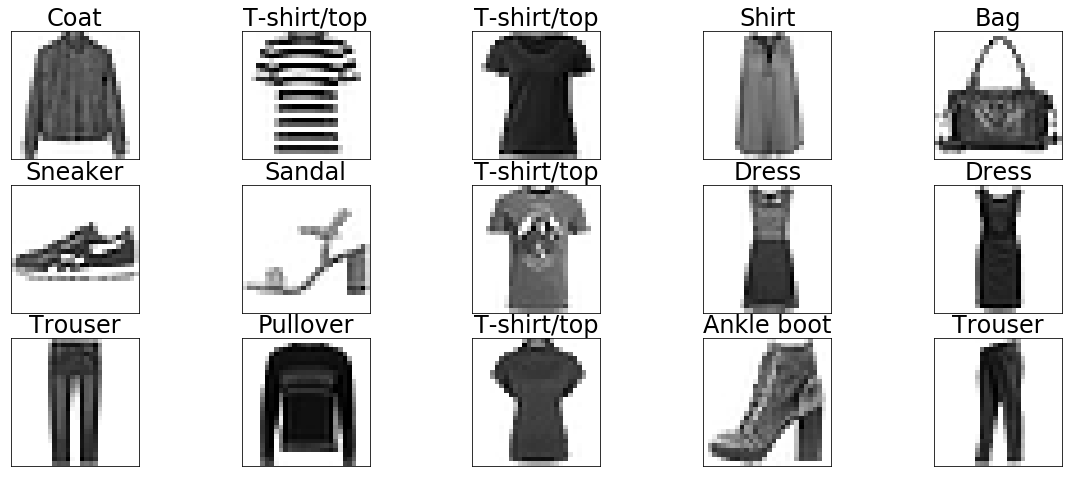

In [10]:
def plot_samples(x, y, n_samples=15, labels=None):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      if labels:
        ax.set_title("{}".format(labels[y[index]]))
      else:
        ax.set_title("{}".format(y[index]))
        
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9


plot_samples(x_train, y_train, labels=fashion_mnist_labels)
# for mnist digits
# plot_samples(x_train, y_train)        

## Deep CNN Autoencoder

* Encoder uses convolutional layers
* Decoder does deconvoluation
* l2 to compress latent space a bit
* could use l1 to increase sparsity of embedding when having dim > 2, to have an additional restriction (often gives better results)
*  rounded accuracy count how many pixels match approximately

In [0]:
# how many pixels match approximately

@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
# the most important part: decide between direct embedding (2) and umap (32), 128 for reconstruction
encoding_dim = 32
# encoding_dim = 2
# encoding_dim = 128

In [13]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential

from tensorflow import keras

conv_encoder = Sequential([
    Input(shape=(x_res, y_res)),
    Reshape((x_res, y_res, 1)),
    Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Flatten(),
    # this creates our latent representation
    Dense(encoding_dim, activation="relu", 
          # activity_regularizer=keras.regularizers.l2(1e-4),
          # activity_regularizer=keras.regularizers.l1(5e-4)),
          activity_regularizer=keras.regularizers.l1_l2(l1=1e-4, l2=1e-4)
         ),

])
conv_decoder = Sequential([
    # this accepts the latent representation
    Input(shape=(encoding_dim)),
    Reshape((1, 1, encoding_dim)),
    Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="relu"),
    Conv2DTranspose(16, kernel_size=3, strides=2, padding="valid", activation="relu"),
    Conv2DTranspose(8, kernel_size=3, strides=2, padding="same", activation="relu"),
    Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    Reshape((x_res, y_res))
])
conv_ae = Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer='adam', metrics=[rounded_accuracy])

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0

In [14]:
%%time

BATCH_SIZE = 2048
EPOCHS = 50

history = conv_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

CPU times: user 46.2 s, sys: 14.1 s, total: 1min
Wall time: 1min 8s


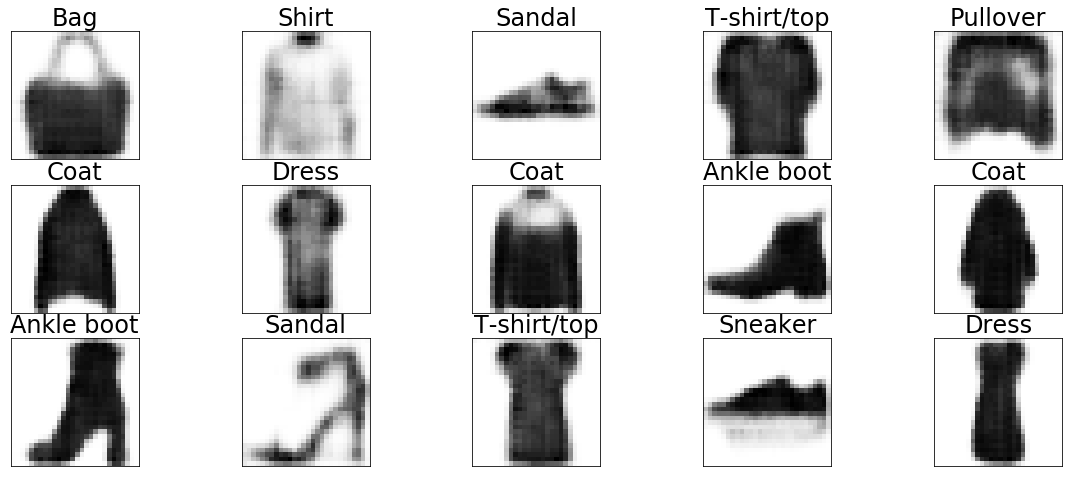

In [15]:
x_test_pred = conv_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# plot_samples(x_test_pred, y_test)

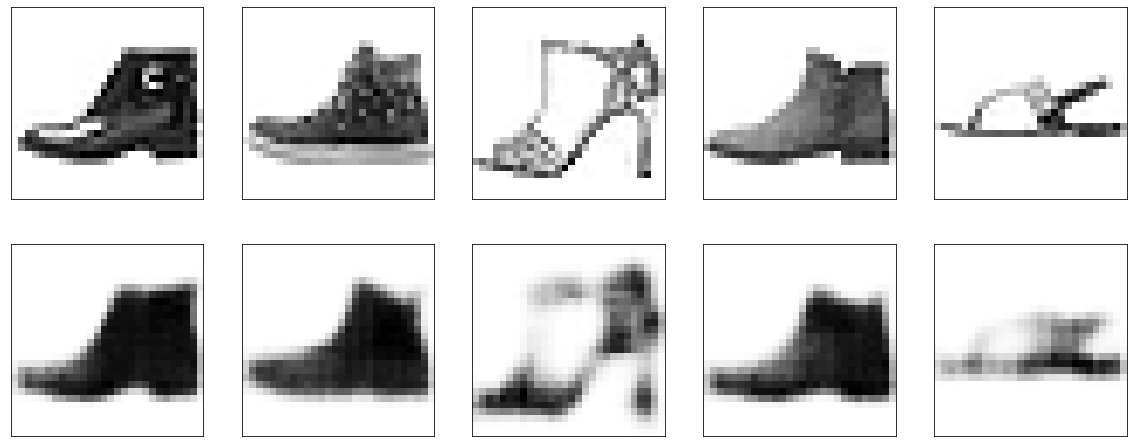

In [16]:
def compare_samples(x, x_pred, n_samples=5):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      ax.imshow(x_pred[index].reshape(x_res, y_res), cmap="binary")
      
compare_samples(x_test, x_test_pred)

In [17]:
embedded_imgs = conv_encoder.predict(x_test)
embedded_imgs.shape

(10000, 128)

### Checking the numbers of zeros and overall average

In [18]:
embedded_imgs[0]

array([0.        , 0.883467  , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00957176, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.5697871 , 0.        ,
       0.        , 0.07539552, 0.        , 0.        , 0.        ,
       0.57517207, 0.        , 0.        , 0.16193692, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.36602306,
       0.        , 0.48884374, 0.        , 0.15820837, 0.29469073,
       0.12348004, 0.        , 0.        , 0.39969027, 0.        ,
       0.244852  , 0.        , 0.        , 0.72216403, 0.        ,
       0.26398832, 0.        , 0.        , 0.        , 0.7578834 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.17544551, 0.        ,
       0.        , 0.        , 0.2088734 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.4575309 , 0.08382

In [19]:
embedded_imgs[500]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.402117  , 0.        , 0.        , 0.        ,
       0.00358118, 0.        , 0.        , 0.93678963, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.44781002, 0.35211623, 0.        , 0.        , 0.        ,
       0.4325915 , 0.        , 0.        , 0.09287183, 0.        ,
       0.17263345, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.15437701, 0.        , 0.        , 0.00766142, 0.        ,
       0.        , 0.        , 0.2629521 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.35020

In [20]:
tf.reduce_mean(embedded_imgs).numpy(), tf.reduce_mean(encoding_dim - tf.math.count_nonzero(embedded_imgs, axis=1)).numpy()

(0.08723263, 98)

## Looking at our embeddings

need to reduce to 2 dim to make them plotable

In [0]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
import umap

In [22]:
%%time

if encoding_dim == 2:
  embeddings_2d = embedded_imgs
else:
  print('reducing dim using umap')
  reducer = umap.UMAP(random_state=42)
  embeddings_2d = reducer.fit_transform(embedded_imgs)

reducing dim using umap


/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True

CPU times: user 34.6 s, sys: 261 ms, total: 34.8 s
Wall time: 34.3 s


In [23]:
embeddings_2d.shape

(10000, 2)

In [24]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

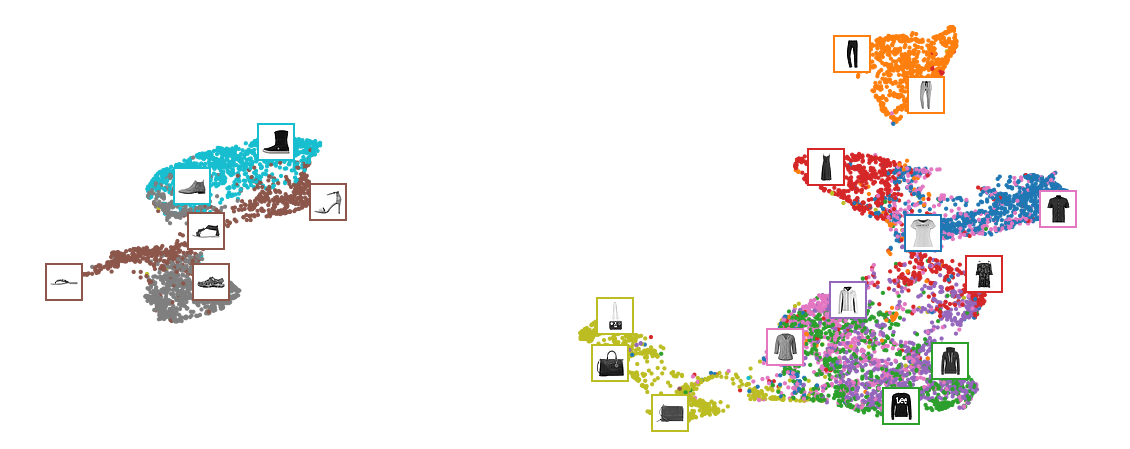

In [25]:
# how far need to labels be from each other in order not to clutter everthing
# might need a bit of adjustment 
min_dist = 0.2

# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > min_dist: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");

## Exercise

* Run the experiment both with 32 latent dimes and UMAP and directly with 2d (don't use regularization with 2d, it is already restricted enough)
* Experiment with l1 and l2 regualrization, what can you observe?
* Can you explain the 2d plot?
  * Are all classes seperated in equal quality?
* Use mnist digits dataset instead of fashion mninst
  * What differences do you see?
  * Can you explain?

# STOP HERE

## So - We turned a concept into a low-dim latent representation

### What is the benefit apart from it being cool?

## Application: Reconstructing Noisy Data

## First let's create some noisy images

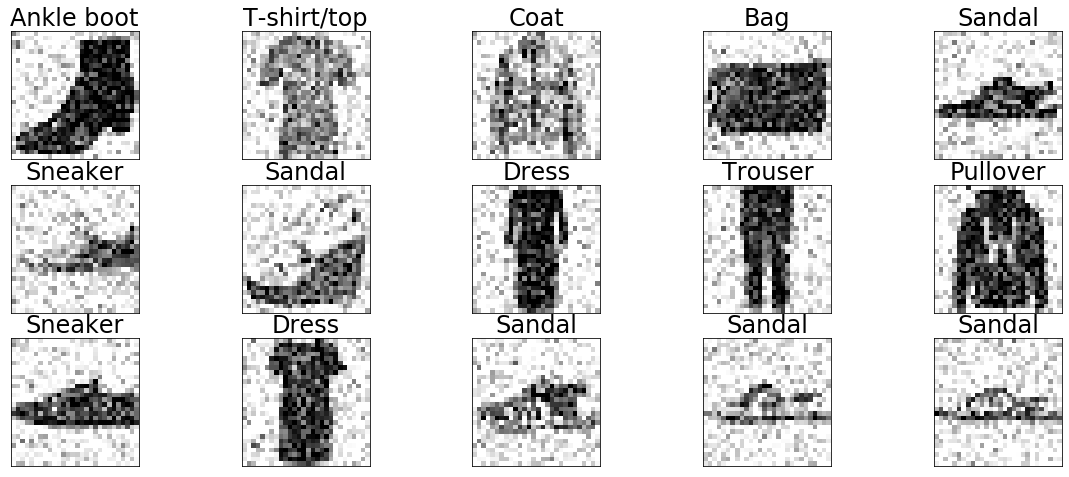

In [26]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

plot_samples(x_train_noisy, y_train, labels=fashion_mnist_labels)

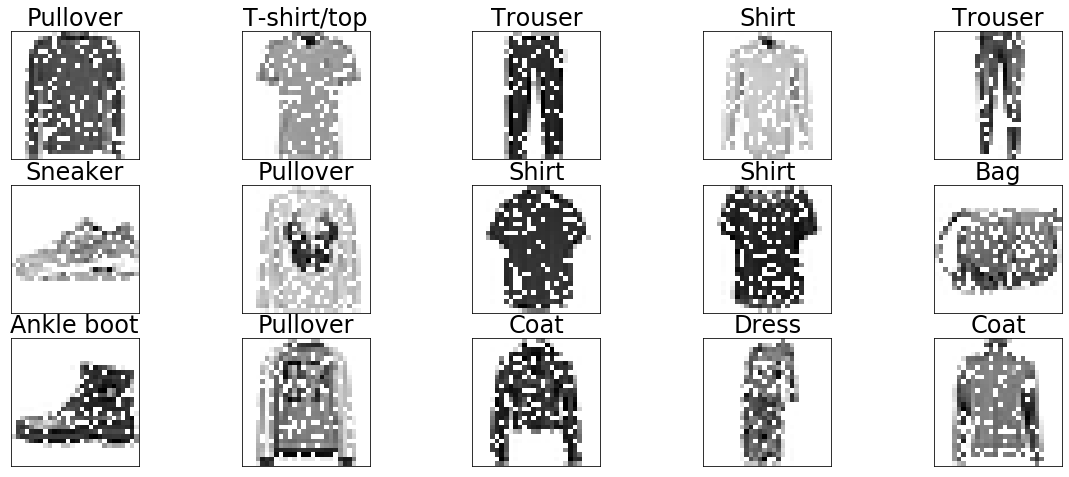

In [27]:
dropout = keras.layers.Dropout(0.2)

x_train_noisy = dropout(x_train, training=True).numpy()
x_test_noisy = dropout(x_test, training=True).numpy()

plot_samples(x_train_noisy, y_train, labels=fashion_mnist_labels)

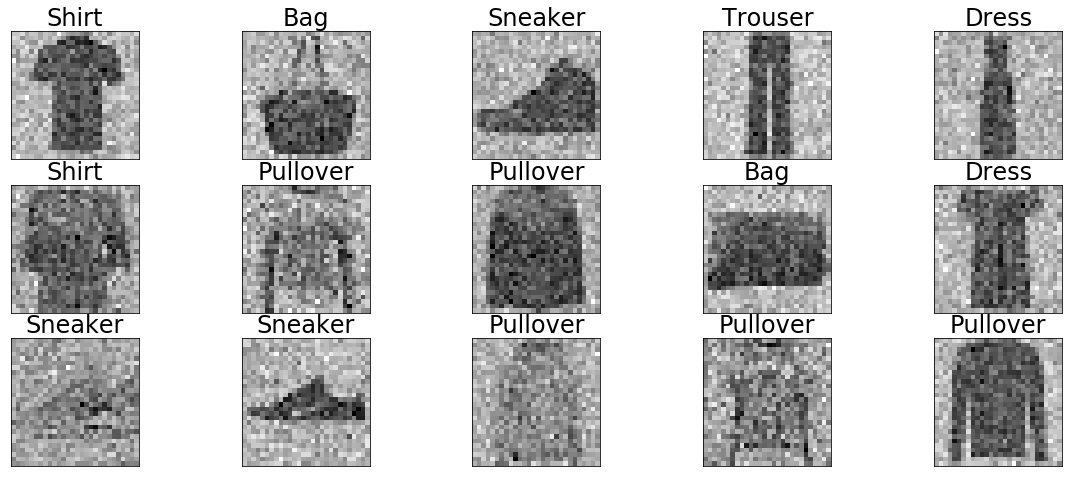

In [28]:
noise = keras.layers.GaussianNoise(0.2)

x_train_noisy = noise(x_train, training=True).numpy()
x_test_noisy = noise(x_test, training=True).numpy()

plot_samples(x_train_noisy, y_train, labels=fashion_mnist_labels)

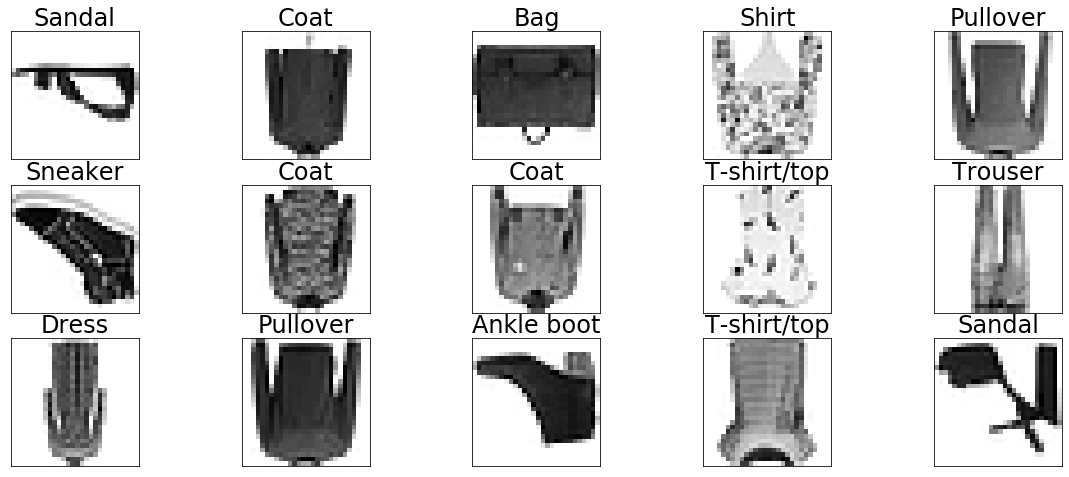

In [29]:
x_train_noisy = tf.image.flip_left_right(x_train).numpy()
x_test_noisy = tf.image.flip_left_right(x_test).numpy()

plot_samples(x_train_noisy, y_train, labels=fashion_mnist_labels)

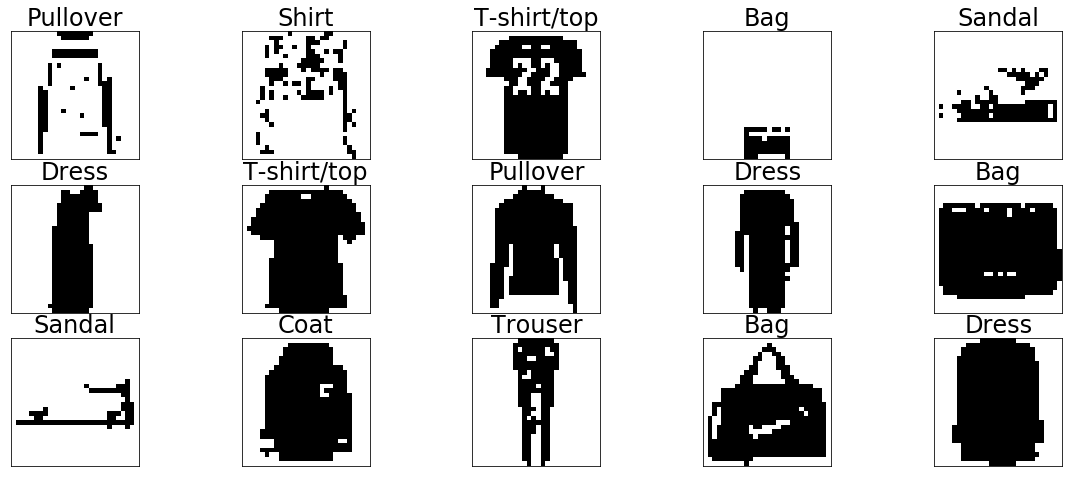

In [30]:
threshold = 0.5

x_train_noisy = (x_train > threshold).astype(float)
x_test_noisy =  (x_test > threshold).astype(float)

plot_samples(x_train_noisy, y_train, labels=fashion_mnist_labels)

## Now we train the autoencoder to reproduce original from noisy input

In [31]:
%%time

BATCH_SIZE = 256
EPOCHS = 50

denoising_ae = Sequential([conv_encoder, conv_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer='adam', metrics=[rounded_accuracy])

history = denoising_ae.fit(x = x_train_noisy,
                    y = x_train,
                    validation_data=(x_test_noisy, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min 56s, sys: 12.9 s, total: 2min 9s
Wall time: 1min 38s


In [32]:
loss, acc = denoising_ae.evaluate(x = x_train_noisy, y = x_train, batch_size=BATCH_SIZE, verbose=0)
acc

0.9478945

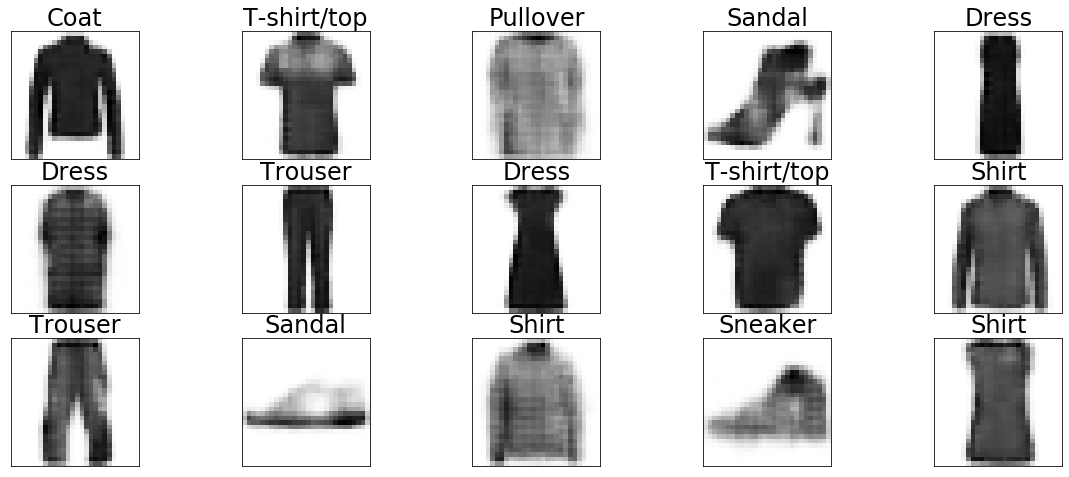

In [33]:
x_test_pred = denoising_ae.predict(x_test_noisy)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# plot_samples(x_test_pred, y_test)

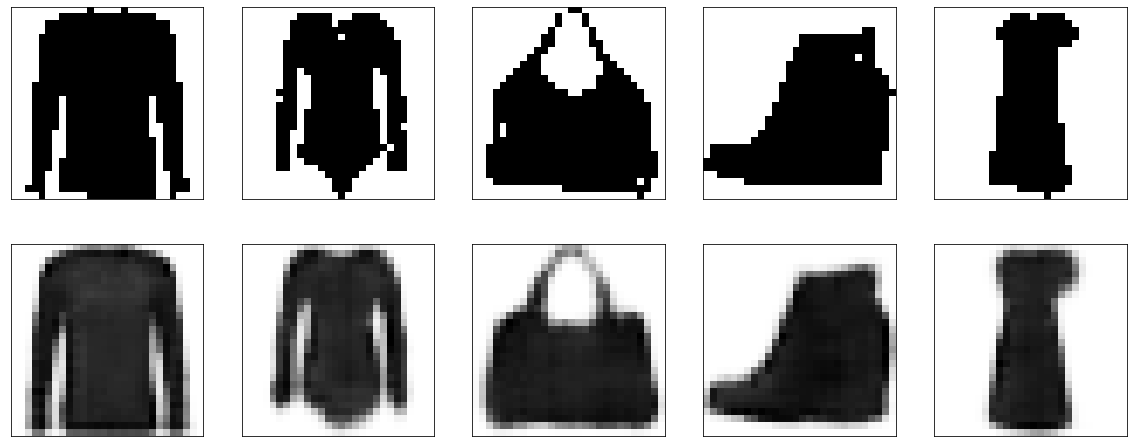

In [34]:
x_test_pred = denoising_ae.predict(x_test_noisy)

compare_samples(x_test_noisy, x_test_pred)

## Exercise

* Try reconstruction an all kinds of noise
* Increase latent space for better results 
* Can you think of other kinds of noises or or kinds of noisy data?